# Import the sample data into BigQuery and Datastore

This notebook is the first of two notebooks that guide you through completing the prerequisites for running the [Real-time Item-to-item Recommendation with BigQuery ML Matrix Factorization and ScaNN](https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/recommendation-system/bqml-scann) solution.

Use this notebook to complete the following tasks:

1. Importing the `playlist` table from the public BigQuery dataset to your BigQuery dataset.
1. Creating the `vw_item_groups` view that contains the item data used to compute item co-occurence.
1. Exporting song title and artist information to Datastore to make it available for lookup when making similar song recommendations. 

Before starting this notebook, you must [set up the GCP environment](https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/recommendation-system/bqml-scann#set-up-the-gcp-environment).

After completing this notebook, run the [00_prep_bq_procedures](00_prep_bq_procedures.ipynb) notebook to complete the solution prerequisites.

## Setup

Install the required Python packages, configure the environment variables, and authenticate your GCP account. 

In [ ]:
!pip install -q -U apache-beam[gcp]

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

### Import libraries

In [ ]:
import os
from datetime import datetime
import apache_beam as beam
from apache_beam.io.gcp.datastore.v1new.datastoreio import WriteToDatastore

### Configure GCP environment settings

Update the following variables to reflect the values for your GCP environment:

+ `PROJECT_ID`: The ID of the Google Cloud project you are using to implement this solution.
+ `BUCKET`: The name of the Cloud Storage bucket you created to use with this solution. The `BUCKET` value should be just the bucket name, so `myBucket` rather than `gs://myBucket`.
+ `BQ_REGION`: The region to use for the BigQuery dataset.
+ `DF_REGION`: The region to use for the Dataflow job. Choose the same region that you used for the `BQ_REGION` variable to avoid issues around reading/writing in different locations.

In [ ]:
PROJECT_ID = 'yourProject' # Change to your project.
BUCKET = 'yourBucketName' # Change to the bucket you created.
BQ_REGION = 'yourBigQueryRegion' # Change to your BigQuery region.
DF_REGION = 'yourDataflowRegion' # Change to your Dataflow region.
BQ_DATASET_NAME = 'recommendations'
BQ_TABLE_NAME = 'playlist'
DS_KIND = 'song'

!gcloud config set project $PROJECT_ID

### Authenticate your GCP account
This is required if you run the notebook in Colab. If you use an AI Platform notebook, you should already be authenticated.

In [ ]:
try:
  from google.colab import auth
  auth.authenticate_user()
  print("Colab user is authenticated.")
except: pass

## Copy the public playlist data into your BigQuery dataset

### Create the BigQuery dataset

In [ ]:
!bq mk --dataset \
    --location={BQ_REGION} \
    --project_id={PROJECT_ID} \
    --headless=True \
    {PROJECT_ID}:{BQ_DATASET_NAME}

### Define the Dataflow pipeline

The pipeline selects songs where the `track_data_title` field isn't NULL and the `track_data_id` field is greater than 0.

In [ ]:
def run_copy_bq_data_pipeline(args):

  schema = 'list_Id:INT64, track_Id:INT64, track_title:STRING, track_artist:STRING'

  query = '''
    SELECT 
      id list_Id, 
      tracks_data_id track_Id, 
      tracks_data_title track_title,
      tracks_data_artist_name track_artist
    FROM `bigquery-samples.playlists.playlist`
    WHERE tracks_data_title IS NOT NULL AND tracks_data_id > 0
    GROUP BY list_Id, track_Id, track_title, track_artist;
  '''

  pipeline_options = beam.options.pipeline_options.PipelineOptions(**args)
  with beam.Pipeline(options=pipeline_options) as pipeline:

    _ = (
        pipeline
        | 'ReadFromBigQuery' >> beam.io.Read(beam.io.BigQuerySource(
            project=PROJECT_ID, query=query, use_standard_sql=True))
        | 'WriteToBigQuery' >> beam.io.WriteToBigQuery(
            table=BQ_TABLE_NAME, dataset=BQ_DATASET_NAME, project=PROJECT_ID,
            schema=schema, 
            create_disposition='CREATE_IF_NEEDED',
            write_disposition='WRITE_TRUNCATE'
        )
    )


### Run the Dataflow pipeline

This pipeline takes approximately 15 minutes to run.

In [ ]:
DATASET = 'playlist'
RUNNER = 'DataflowRunner'

job_name = f'copy-bigquery-{datetime.utcnow().strftime("%y%m%d%H%M%S")}'

args = {
    'job_name': job_name,
    'runner': RUNNER,
    'project': PROJECT_ID,
    'temp_location': f'gs://{BUCKET}/dataflow_tmp',
    'region': DF_REGION
}

print("Pipeline args are set.")

In [ ]:
print("Running pipeline...")
%time run_copy_bq_data_pipeline(args)
print("Pipeline is done.")

## Create the `vw_item_groups` view

Create the `recommendations.vw_item_groups` view to focus on song and playlist data.

To adapt this view to your own data, you would need to map your item identifier, for example product SKU, to `item_Id`, and your context identifier, for example purchase order number, to `group_Id`.

In [ ]:
%%bigquery  --project $PROJECT_ID

CREATE OR REPLACE VIEW `recommendations.vw_item_groups`
AS
SELECT
  list_Id AS group_Id,
  track_Id AS item_Id
FROM  
  `recommendations.playlist` 

## Export song information to Datastore

Export data from the `track_title` and `artist` fields to Datastore.

### Define the Dataflow pipeline

In [ ]:
def create_entity(song_info, kind):

  from apache_beam.io.gcp.datastore.v1new.types import Entity
  from apache_beam.io.gcp.datastore.v1new.types import Key

  track_Id = song_info.pop("track_Id")
  key = Key([kind, track_Id])
  song_entity = Entity(key)
  song_entity.set_properties(song_info)
  return song_entity

def run_export_to_datatore_pipeline(args):

    query = f'''
      SELECT  
        track_Id, 
        MAX(track_title) track_title, 
        MAX(track_artist) artist
      FROM 
        `{BQ_DATASET_NAME}.{BQ_TABLE_NAME}`
      GROUP BY track_Id
    '''

    pipeline_options = beam.options.pipeline_options.PipelineOptions(**args)
    with beam.Pipeline(options=pipeline_options) as pipeline:

      _ = (
        pipeline
        | 'ReadFromBigQuery' >> beam.io.Read(beam.io.BigQuerySource(
            project=PROJECT_ID, query=query, use_standard_sql=True))
        | 'ConvertToDatastoreEntity' >> beam.Map(create_entity, DS_KIND)
        | 'WriteToDatastore' >> WriteToDatastore(project=PROJECT_ID)
      )


### Run the Dataflow pipeline

This pipeline takes approximately 15 minutes to run.

In [ ]:
import os
from datetime import datetime

DATASET = 'playlist'
RUNNER = 'DataflowRunner'

job_name = f'load-datastore-{datetime.utcnow().strftime("%y%m%d%H%M%S")}'

args = {
    'job_name': job_name,
    'runner': RUNNER,
    'project': PROJECT_ID,
    'temp_location': f'gs://{BUCKET}/dataflow_tmp',
    'region': DF_REGION
}

print("Pipeline args are set.")

In [ ]:
print("Running pipeline...")
%time run_export_to_datatore_pipeline(args)
print("Pipeline is done.")

After running the pipeline, you can view the song entries on the [Datastore Entities page](https://pantheon.corp.google.com/datastore/entities):


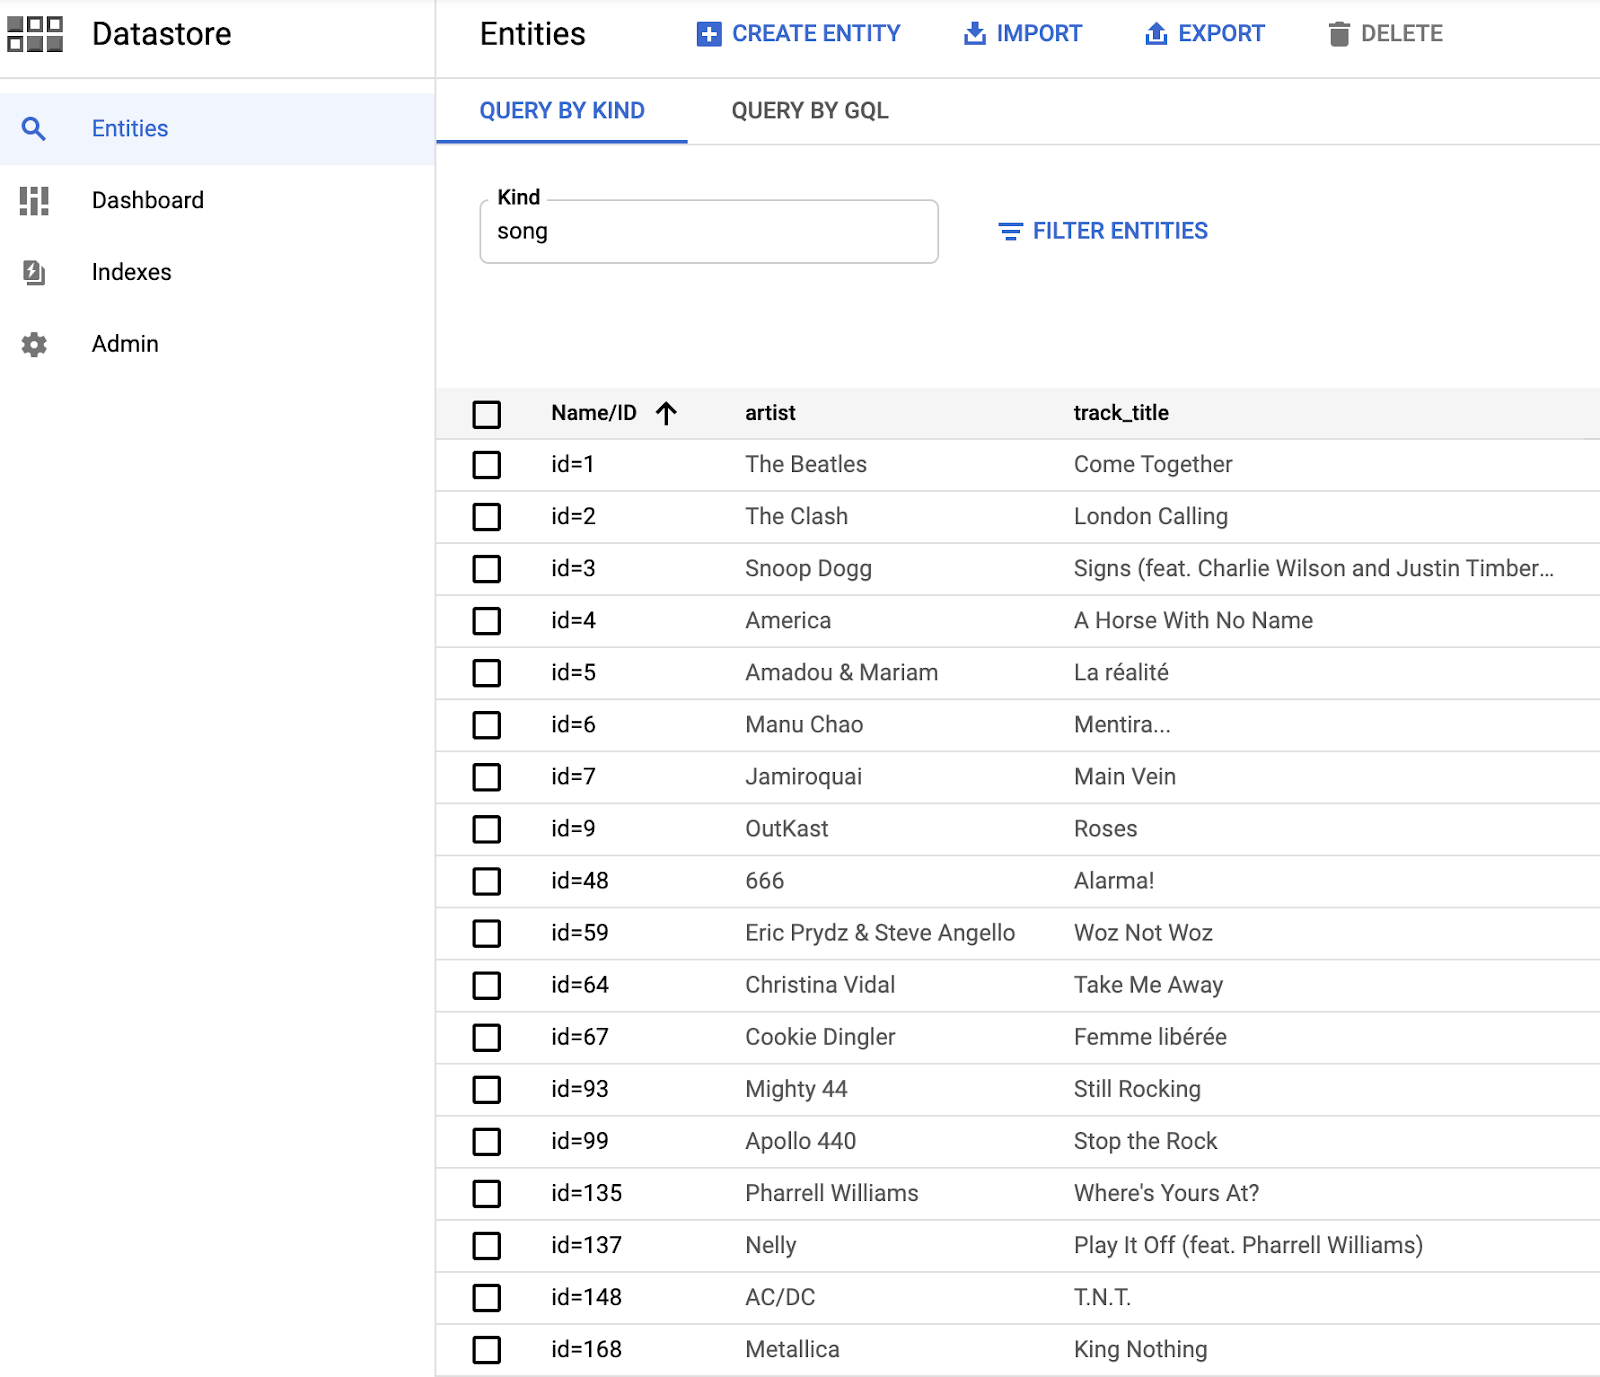

## License

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License. You may obtain a copy of the License at: http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 

See the License for the specific language governing permissions and limitations under the License.

**This is not an official Google product but sample code provided for an educational purpose**